**Skip-Gram**

In [8]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import itertools

In [2]:
class Dataset:
    def __init__(self, x, y, v2i, i2v):
        self.x, self.y = x, y
        self.v2i, self.i2v = v2i, i2v
        self.vocab = v2i.keys()

    def sample(self, n):
        b_idx = np.random.randint(0, len(self.x), n)
        bx, by = self.x[b_idx], self.y[b_idx]
        return bx, by

    @property
    def num_word(self):
        return len(self.v2i)

In [3]:
def process_w2v_data(corpus, skip_window=2, method="skip_gram"):
    all_words = [sentence.split(" ") for sentence in corpus]
    all_words = np.array(list(itertools.chain(*all_words)))
    # vocab sort by decreasing frequency for the negative sampling below (nce_loss).
    vocab, v_count = np.unique(all_words, return_counts=True)
    vocab = vocab[np.argsort(v_count)[::-1]]

    print("all vocabularies sorted from more frequent to less frequent:\n", vocab)
    v2i = {v: i for i, v in enumerate(vocab)}
    i2v = {i: v for v, i in v2i.items()}

    # pair data
    pairs = []
    js = [i for i in range(-skip_window, skip_window + 1) if i != 0]

    for c in corpus:
        words = c.split(" ")
        w_idx = [v2i[w] for w in words]
        if method == "skip_gram":
            for i in range(len(w_idx)):
                for j in js:
                    if i + j < 0 or i + j >= len(w_idx):
                        continue
                    pairs.append((w_idx[i], w_idx[i + j]))  # (center, context) or (feature, target)
        elif method.lower() == "cbow":
            for i in range(skip_window, len(w_idx) - skip_window):
                context = []
                for j in js:
                    context.append(w_idx[i + j])
                pairs.append(context + [w_idx[i]])  # (contexts, center) or (feature, target)
        else:
            raise ValueError
    pairs = np.array(pairs)
    print("5 example pairs:\n", pairs[:5])
    if method.lower() == "skip_gram":
        x, y = pairs[:, 0], pairs[:, 1]
    elif method.lower() == "cbow":
        x, y = pairs[:, :-1], pairs[:, -1]
    else:
        raise ValueError
    return Dataset(x, y, v2i, i2v)

In [4]:
corpus = [
    # numbers
    "5 2 4 8 6 2 3 6 4",
    "4 8 5 6 9 5 5 6",
    "1 1 5 2 3 3 8",
    "3 6 9 6 8 7 4 6 3",
    "8 9 9 6 1 4 3 4",
    "1 0 2 0 2 1 3 3 3 3 3",
    "9 3 3 0 1 4 7 8",
    "9 9 8 5 6 7 1 2 3 0 1 0",

    # alphabets, expecting that 9 is close to letters
    "a t g q e h 9 u f",
    "e q y u o i p s",
    "q o 9 p l k j o k k o p",
    "h g y i u t t a e q",
    "i k d q r e 9 e a d",
    "o p d g 9 s a f g a",
    "i u y g h k l a s w",
    "o l u y a o g f s",
    "o p i u y g d a s j d l",
    "u k i l o 9 l j s",
    "y g i s h k j l f r f",
    "i o h n 9 9 d 9 f a 9",
]

**Skip-Gram Model**

In [5]:
class SkipGram(keras.Model):
    def __init__(self, v_dim, emb_dim):
        super().__init__()
        self.v_dim = v_dim
        self.embeddings = keras.layers.Embedding(
            input_dim=v_dim, output_dim=emb_dim,       # [n_vocab, emb_dim]
            embeddings_initializer=keras.initializers.RandomNormal(0., 0.1),
        )

        # noise-contrastive estimation
        self.nce_w = self.add_weight(
            name="nce_w", shape=[v_dim, emb_dim],
            initializer=keras.initializers.TruncatedNormal(0., 0.1))  # [n_vocab, emb_dim]
        self.nce_b = self.add_weight(
            name="nce_b", shape=(v_dim,),
            initializer=keras.initializers.Constant(0.1))  # [n_vocab, ]

        self.opt = keras.optimizers.Adam(0.01)

    def call(self, x, training=None, mask=None):
        # x.shape = [n, ]
        o = self.embeddings(x)      # [n, emb_dim]
        return o

    # negative sampling: take one positive label and num_sampled negative labels to compute the loss
    # in order to reduce the computation of full softmax
    def loss(self, x, y, training=None):
        embedded = self.call(x, training)
        return tf.reduce_mean(
            tf.nn.nce_loss(
                weights=self.nce_w, biases=self.nce_b, labels=tf.expand_dims(y, axis=1),
                inputs=embedded, num_sampled=5, num_classes=self.v_dim))

    def step(self, x, y):
        with tf.GradientTape() as tape:
            loss = self.loss(x, y, True)
            grads = tape.gradient(loss, self.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.trainable_variables))
        return loss.numpy()

In [6]:
def train(model, data):
    for t in range(2500):
        bx, by = data.sample(8)
        loss = model.step(bx, by)
        if t % 200 == 0:
            print("step: {} | loss: {}".format(t, loss))

**Process**

In [9]:
d = process_w2v_data(corpus, skip_window=2, method="skip_gram")
d

all vocabularies sorted from more frequent to less frequent:
 ['9' '3' 'o' '6' 'a' '1' 'i' 'g' 's' '4' 'l' 'k' '8' 'u' '2' 'd' '5' 'y'
 'f' 'e' 'h' 'p' 'q' '0' 'j' '7' 't' 'r' 'w' 'n']
5 example pairs:
 [[16 14]
 [16  9]
 [14 16]
 [14  9]
 [14 12]]


In [10]:
m = SkipGram(d.num_word, 2)

In [11]:
train(model=m,data=d)

step: 0 | loss: 5.946027755737305
step: 200 | loss: 2.8823986053466797
step: 400 | loss: 2.6079299449920654
step: 600 | loss: 2.9627768993377686
step: 800 | loss: 2.55483341217041
step: 1000 | loss: 2.5986528396606445
step: 1200 | loss: 2.3097195625305176
step: 1400 | loss: 2.810511589050293
step: 1600 | loss: 2.3073134422302246
step: 1800 | loss: 2.386871814727783
step: 2000 | loss: 2.0080699920654297
step: 2200 | loss: 1.7148692607879639
step: 2400 | loss: 1.8562114238739014


**Plotting**

In [12]:
import matplotlib.pyplot as plt

In [13]:
def show_w2v_word_embedding(model, data, path=None):
    word_emb = model.embeddings.get_weights()[0]
    for i in range(data.num_word):
        c = "blue"
        try:
            int(data.i2v[i])
        except ValueError:
            c = "red"
        plt.text(word_emb[i, 0], word_emb[i, 1], s=data.i2v[i], color=c, weight="bold")
    plt.xlim(word_emb[:, 0].min() - .5, word_emb[:, 0].max() + .5)
    plt.ylim(word_emb[:, 1].min() - .5, word_emb[:, 1].max() + .5)
    plt.xticks(())
    plt.yticks(())
    plt.xlabel("embedding dim1")
    plt.ylabel("embedding dim2")
    plt.show()

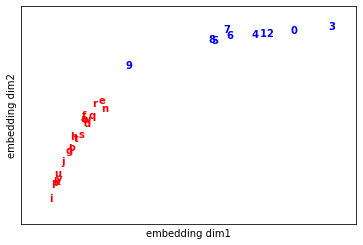

In [15]:
show_w2v_word_embedding(model=m, data=d)